In [1]:
from collections import OrderedDict

import gpflow as gpf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import simenvs
import tensorflow as tf
import tensorflow_probability as tfp
from experiments.plot.callbacks.controller import (
    plot_trajectories_over_desired_gating_gp,
    plot_trajectories_over_desired_mixing_prob,
)
from experiments.plot.utils import plot_env_cmap
from experiments.utils import sample_env_trajectories
from gpflow import default_float
from gpflow.functions import Constant
from gpflow.inducing_variables import InducingPoints, SharedIndependentInducingVariables
from gpflow.kernels import Matern52, SeparateIndependent
from gpflow.likelihoods import Gaussian
from IPython.display import clear_output
from moderl.controllers import ExplorativeController
from moderl.custom_types import Dataset, State
from moderl.dynamics import ModeRLDynamics
from moderl.objectives import joint_gating_function_entropy
from moderl.reward_functions import (
    ControlQuadraticRewardFunction,
    StateDiffRewardFunction,
)
from moderl.rollouts import (
    collect_data_from_env,
    rollout_trajectory_optimisation_controller_in_env,
)
from mosvgpe.experts import SVGPExpert
from mosvgpe.gating_networks import SVGPGatingNetwork
from mosvgpe.mixture_of_experts import MixtureOfSVGPExperts
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
params = {"text.usetex": True, "image.cmap": "bwr_r"}
plt.rcParams.update(params)

tfd = tfp.distributions

random_seed = 42
tf.keras.utils.set_random_seed(random_seed)  # Set random seed for reproducibility

/Users/scannea1/python-projects/ModeRL/.direnv/python-3.9.13/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/scannea1/python-projects/ModeRL/.direnv/python-3.9.13/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


## Plotting utilities
Let's create functions for visualising the environment and each episode of training. 

In [2]:
LABELS = {
    "env": r"Environment $\bar{\mathbf{s}}_{\pi_{i}}$",
    "dynamics": r"Dynamics $\bar{\mathbf{s}}^{f_{k^*}}_{\pi_{i}}$",
}
COLORS = {"env": "c", "dynamics": "m"}
LINESTYLES = {"env": "-", "dynamics": "-"}
MARKERS = {"env": "*", "dynamics": "."}
LEVELS = np.linspace(0, 1, 11)  # contour levels for probabilities

In [3]:
def create_test_inputs(num_test: int = 400) -> Dataset:
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(-4, 3, sqrtN)
    yy = np.linspace(-4, 4, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    TEST_INPUTS = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    zeros = np.zeros((num_test, 2))
    TEST_INPUTS = np.concatenate([TEST_INPUTS, zeros], -1)
    return TEST_INPUTS


TEST_INPUTS = create_test_inputs(num_test=40000)

In [24]:
def plot_episode(episode: int, explorative_controller: ExplorativeController):
    """Plot agent's trajectory over it's belief of being in desired mode at episode"""
    #     clear_output(True)
    fig, ax = plt.subplots()

    # Plot agent's belief in being in desired dynamics mode (contour)
    probs = explorative_controller.dynamics.mosvgpe.gating_network.predict_mixing_probs(
        TEST_INPUTS
    )
    contf = ax.tricontourf(
        TEST_INPUTS[:, 0],
        TEST_INPUTS[:, 1],
        probs[:, explorative_controller.dynamics.desired_mode],
        levels=LEVELS,
    )

    # Plot environment/dynamics trajectories
    env_traj = rollout_trajectory_optimisation_controller_in_env(
        env=env, start_state=start_state, controller=explorative_controller
    )
    dynamics_traj = explorative_controller.rollout_in_dynamics().mean()
    for traj, key in zip([env_traj, dynamics_traj], ["env", "dynamics"]):
        ax.plot(
            traj[:, 0],
            traj[:, 1],
            label=LABELS[key],
            color=COLORS[key],
            linestyle=LINESTYLES[key],
            linewidth=0.3,
            marker=MARKERS[key],
        )

    # Plot the true mode boundary from the environment
    test_states = TEST_INPUTS[:, 0:2]
    mode_probs = []
    for test_state in test_states:
        pixel = env.state_to_pixel(test_state)
        mode_probs.append(env.gating_bitmap[pixel[0], pixel[1]])
    mode_probs = tf.stack(mode_probs, 0)
    ax.tricontour(
        test_states[:, 0],
        test_states[:, 1],
        mode_probs.numpy(),
        [0.5],
        colors=["red"],
        linestyles="dashed",
        alpha=1.0,
        zorder=50,
    )

    # Plot the delta mode constraint
    mixing_probs = (
        explorative_controller.dynamics.mosvgpe.gating_network.predict_mixing_probs(
            TEST_INPUTS
        )
    )
    ax.tricontour(
        TEST_INPUTS[:, 0],
        TEST_INPUTS[:, 1],
        mixing_probs[:, explorative_controller.dynamics.desired_mode].numpy(),
        [explorative_controller.mode_satisfaction_prob],
        colors=["k"],
    )

    # Plot state and target state
    plot_start_end_pos(ax, start_state, target_state)

    # Add a legend
    handles, labels = fig.gca().get_legend_handles_labels()
    handles.append(mpl.lines.Line2D([1], [1], color="r", alpha=0.5, linestyle="dashed"))
    labels.append("Mode boundary")
    handles.append(mpl.lines.Line2D([1], [1], color="k"))
    labels.append(r"$\delta$-mode constraint")
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(
        by_label.values(), by_label.keys(), loc="lower center", ncol=len(by_label)
    )

    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(contf, use_gridspec=True, cax=cax)
    cbar.set_label(
        r"$\Pr(\alpha=k^* \mid \mathbf{s}, \mathcal{D}_{0:" + str(episode) + "})$"
    )

    # Neaten axis
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [5]:
def plot_env():
    fig, ax = plt.subplots()

    # Plot the env
    plot_env_cmap(ax, env, TEST_INPUTS)

    # Neaten axis
    plt.xlim([-4, 3])
    plt.ylim([-4, 4])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Create legend
    handles, labels = ax.get_legend_handles_labels()
    cmap = mpl.cm.get_cmap()
    c0 = cmap(0.15)
    c1 = cmap(0.8)
    handles.append(mpl.patches.Patch(color=c1))
    labels.append("Mode 1")
    handles.append(mpl.patches.Patch(color=c0))
    labels.append("Mode 2")
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="lower left")
    return ax


def plot_problem():
    ax = plot_env()
    plot_start_end_pos(ax, start_state, target_state)
    return ax


def plot_data_over_env(data):
    ax = plot_problem()
    handles, labels = ax.get_legend_handles_labels()
    ax.scatter(
        data[0][:, 0],
        data[0][:, 1],
        marker="x",
        color="k",
        linewidth=0.5,
        alpha=0.2,
        label="Observations",
    )

    # Create legend
    handles, labels = ax.get_legend_handles_labels()
    cmap = mpl.cm.get_cmap()
    c0 = cmap(0.15)
    c1 = cmap(0.8)
    handles.append(mpl.patches.Patch(color=c1))
    labels.append("Mode 1")
    handles.append(mpl.patches.Patch(color=c0))
    labels.append("Mode 2")
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="lower left")


def plot_start_end_pos(ax, start_state, target_state):
    bbox = dict(boxstyle="round,pad=0.1", fc="thistle", alpha=1.0)
    ax.annotate(
        "Start",
        (start_state[0, 0], start_state[0, 1] - 0.3),
        horizontalalignment="right",
        verticalalignment="top",
        bbox=bbox,
    )
    ax.annotate(
        "Target",
        (target_state[0, 0] + 0.15, target_state[0, 1]),
        horizontalalignment="left",
        verticalalignment="bottom",
        bbox=bbox,
    )
    ax.scatter(start_state[0, 0], start_state[0, 1], marker="o", color="k", s=40.0)
    ax.scatter(target_state[0, 0], target_state[0, 1], marker="*", color="k", s=250.0)

## Environment
Let's create the environment and visualise it.

No constant_error found in toml config so using default : 0.0


<AxesSubplot: >

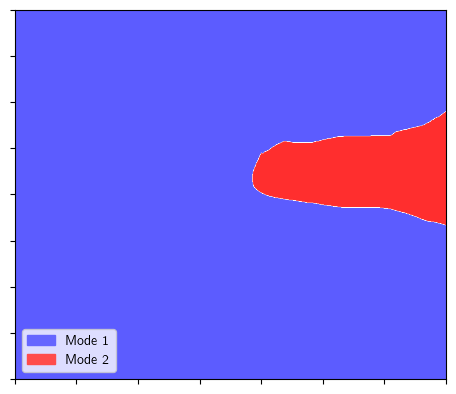

In [6]:
env_name = "velocity-controlled-point-mass/scenario-1"
env = simenvs.make(env_name)
state_dim = env.observation_spec().shape[0]
action_dim = env.action_spec().shape[0]
plot_env()

## Reward function

Our goal is to navigate to a target state $s_f$. Our reward function is given by,

\begin{align}
r(\mathbf{s}_t, \mathbf{a}_t) = -(\mathbf{s}_t - \mathbf{s}_f)^T \mathbf{Q} (\mathbf{s}_t - \mathbf{s}_f)
-\mathbf{a}^T \mathbf{R} \mathbf{a}
\end{align}

where $\mathbf{Q}$ and $\mathbf{R}$ are user-defined, real symmetric positive semi definite and positive definite weight matrices respectively.
In our experiments we set both $\mathbf{Q}$ and $\mathbf{R}$ to be the identify matrix.

In [7]:
start_state = tf.constant([[2.0, -2.5]], dtype=default_float())
target_state = tf.constant([[1.2, 3.0]], dtype=default_float())

<AxesSubplot: >

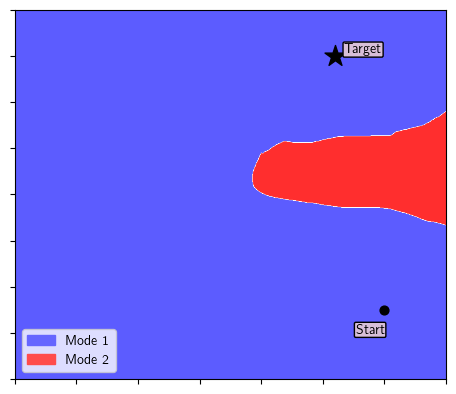

In [8]:
state_diff_reward_fn = StateDiffRewardFunction(
    weight_matrix=1.0 * tf.eye(state_dim, dtype=default_float()),
    target_state=target_state,
)
control_reward_fn = ControlQuadraticRewardFunction(
    weight_matrix=tf.eye(action_dim, dtype=default_float())
)
reward_fn = state_diff_reward_fn + control_reward_fn
plot_problem()

## Sample initial data set
We create out initial dataset $\mathcal{D}_0$ by sampling 50 trajectories with horizon $T=15$ and terminate trajectories if they leave the initial domain (a square of width=1.0 centered at the start state).

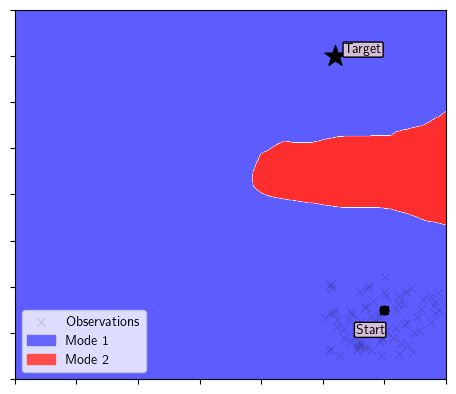

In [9]:
initial_dataset = sample_env_trajectories(
    env=env,
    start_state=start_state,
    horizon=15,
    num_trajectories=50,
    width=1.0,
    random_seed=42,
)
X, Y = initial_dataset
plot_data_over_env(initial_dataset)

## Dynamics model
We use two dynamics modes and configures each mode's sparse variational gaussian process (SVGP) with 50 inducing points. 
Our gating network uses a single gating function and a Bernoulli likelihood. We instantiate the gating fuction's SVGP with 90 inducing points.

In [10]:
num_experts = 2
num_inducing_experts = 50
num_inducing_gating = 90

### Instantiate dynamics modes

In [11]:
def build_SVGPExpert() -> SVGPExpert:
    likelihood = Gaussian(variance=[1.0 for _ in range(state_dim)])
    mean_function = Constant(c=[0.0 for _ in range(state_dim)])
    kernels = [
        Matern52(
            lengthscales=[1.0 for _ in range(state_dim + action_dim)],
            variance=1.0,
        )
        for _ in range(state_dim)
    ]
    kernel = SeparateIndependent(kernels=kernels)
    idx = np.random.choice(range(X.shape[0]), size=num_inducing_experts, replace=False)
    Z = X[idx, ...].reshape(-1, X.shape[1])
    inducing_variable = SharedIndependentInducingVariables(InducingPoints(Z))
    return SVGPExpert(
        kernel=kernel,
        likelihood=likelihood,
        mean_function=mean_function,
        inducing_variable=inducing_variable,
        num_latent_gps=state_dim,
        q_diag=False,
        whiten=True,
    )


experts_list = [build_SVGPExpert() for _ in range(num_experts)]

/Users/scannea1/python-projects/ModeRL/.direnv/python-3.9.13/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


### Instantiate gating network

In [12]:
lengthscales = [0.8, 0.8]
kernel_variance = 1.0
active_dims = [0, 1]

In [13]:
idx = np.random.choice(range(X.shape[0]), size=num_inducing_gating, replace=False)
Z = X[idx, ...].reshape(-1, X.shape[1])
kernel = Matern52(
    lengthscales=lengthscales, variance=kernel_variance, active_dims=active_dims
)
inducing_variable = InducingPoints(Z)
gating_network = SVGPGatingNetwork(
    kernel=kernel,
    inducing_variable=inducing_variable,
    mean_function=None,  # Use zero mean function
    q_diag=False,
    whiten=True,
)

Create the Mixtures of Sparse Variational Gaussian Process Experts (MoSVGPE) model from the list of dynamics modes and the gating network.

In [14]:
mosvgpe = MixtureOfSVGPExperts(experts_list=experts_list, gating_network=gating_network)

Make the gating functions kernel hyperparameters and the turbulent dynamics modes noise_variance not trainable.

In [15]:
gpf.utilities.set_trainable(mosvgpe.gating_network.gp.kernel, False)
gpf.utilities.set_trainable(mosvgpe.experts_list[1].gp.likelihood, False)

## Instantiate dynamics
Create the dynamics model and its early stopping callback.

In [16]:
# Adam optimiser config
learning_rate = 0.01
epsilon = 1e-8
# Keras fit() args
batch_size = 64
epochs = 20000
verbose = False
validation_split = 0.0
# Early stopping callback config
patience = 50
min_delta = 0

In [17]:
dynamics = ModeRLDynamics(
    mosvgpe=mosvgpe,
    state_dim=state_dim,
    desired_mode=0,  # set 0 now and update after training on data
    dataset=initial_dataset,
    learning_rate=learning_rate,
    epsilon=epsilon,
    dynamics_fit_kwargs={
        "batch_size": batch_size,
        "epochs": epochs,
        "verbose": verbose,
        "validation_split": validation_split,
    },
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=patience,
            min_delta=min_delta,
            verbose=0,
            restore_best_weights=True,
        )
    ],
)

## Policy
We initialise our trajectory optimiser with a horizon of $T=15$. We use the previous iteration's solution to warm start the subsequent iteration and set the maximum number of iterations to $150$.

In [18]:
horizon = 15
keep_last_solution = True
max_iterations = 150

We use our joint gating function entropy objective and weight our exploration term with $\beta=10$. We set the $\delta\text{-mode-constraint}=0.2$. 

\begin{align}
&\pi=
\max_{\pi \in \Pi}
\underbrace{\mathbb{E}_{f_{k^*} \sim p(f_{k^*} \mid \mathcal{D}_{0:i})} \left[ J(\pi, f_{k^*}) \right]}_{\text{greedy exploitation}} +
\beta\underbrace{\mathcal{H} \left[
h_{k^*}(\bar{\mathbf{s}}) \mid \bar{\mathbf{s}}, \mathcal{D}_{0:i} \right]}_{\text{exploration}} \\
&\text{s.t. } \underbrace{\mathbb{E}_{f_{k^*} \sim p(f_{k^*} \mid \mathcal{D}_{0:i})} \left[ \Pr(\alpha_{t} = k^* \mid \mathbf{s}_t) \right]
\geq 1-\delta}_{\delta \text{ mode constraint}} \quad \forall t \in \{0, \ldots, T\}.
\end{align}

In [19]:
exploration_weight = 10.0
explorative_objective_fn = joint_gating_function_entropy
mode_satisfaction_prob = 0.8

In [20]:
explorative_controller = ExplorativeController(
    start_state=start_state,
    dynamics=dynamics,
    explorative_objective_fn=explorative_objective_fn,
    reward_fn=reward_fn,
    control_dim=action_dim,
    horizon=horizon,
    max_iterations=max_iterations,
    mode_satisfaction_prob=mode_satisfaction_prob,
    exploration_weight=exploration_weight,
    keep_last_solution=keep_last_solution,
)

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead
2022-10-19 09:37:50.047668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Set the desired mode
We set the desired dynamics mode to the one with lowest transition noise.

In [21]:
def set_desired_mode(dynamics: ModeRLDynamics) -> int:
    """Sets desired mode to one with lowest transition noise
    uses product of output dims
    """
    noise_var_prod = tf.reduce_prod(
        dynamics.mosvgpe.experts_list[0].gp.likelihood.variance
    )
    desired_mode = 0
    for k, expert in enumerate(dynamics.mosvgpe.experts_list):
        if tf.reduce_prod(expert.gp.likelihood.variance) < noise_var_prod:
            noise_var_prod = expert.gp.likelihood.variance
            desired_mode = k
    print("Desired mode is {}".format(desired_mode))
    return desired_mode

## Run the ModeRL loop
We run our ModeRL loop for 40 episodes.
We visualise each episode by rolling out the agent's trajectory in both its dynamics model and the environment.
We plot both of these trajectories over the agent's belief of being in desired mode at the current episode episode.
We further plot the $\delta\text{-mode-constrained}$ region (black line) to show how the constrained regions expands during learning.

In [22]:
num_episodes = 40

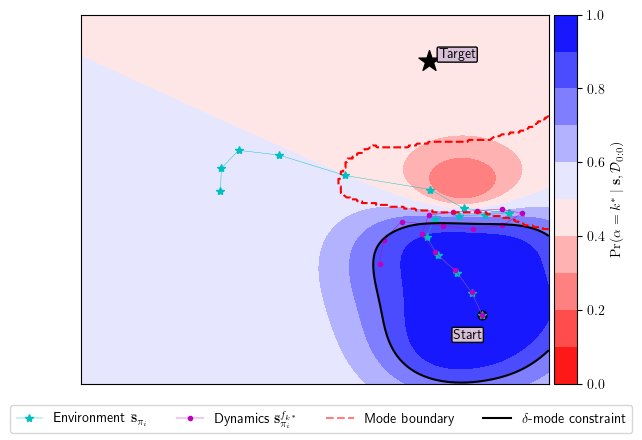

Episode: 0
Finished training dynamics
Desired mode is 0
Finished optimising controller


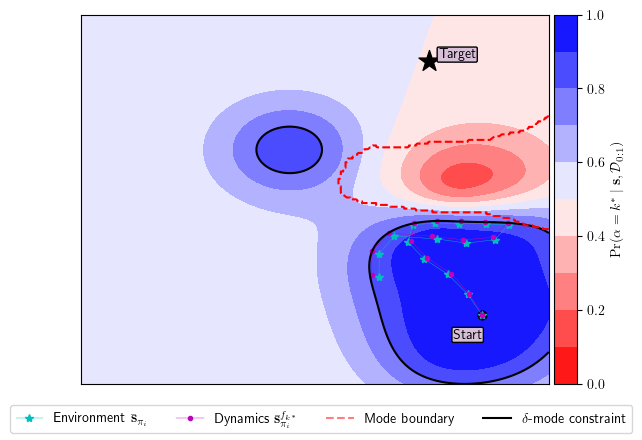

Episode: 1
Finished training dynamics
Finished optimising controller


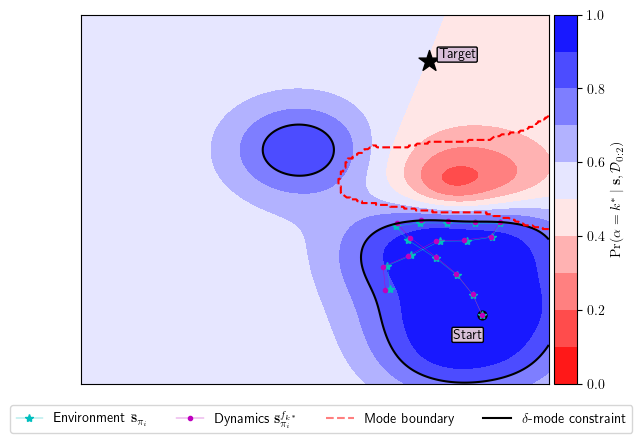

Episode: 2
Finished training dynamics
Finished optimising controller


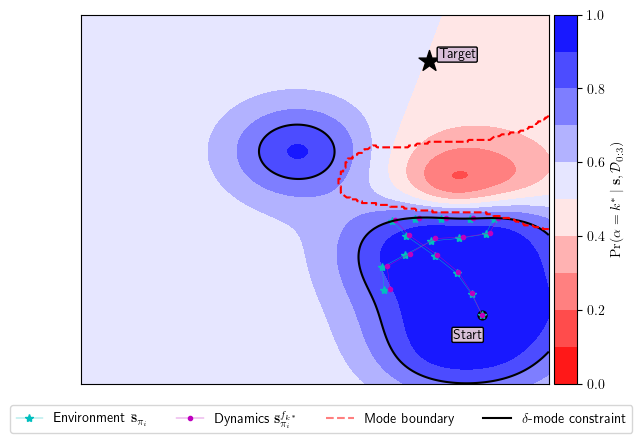

Episode: 3
Finished training dynamics
Finished optimising controller


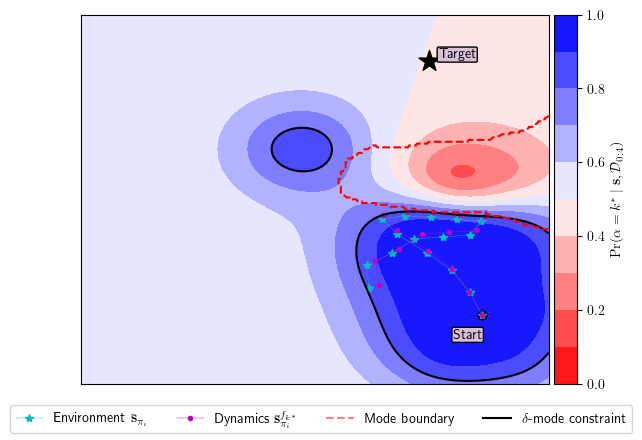

Episode: 4
Finished training dynamics
Finished optimising controller


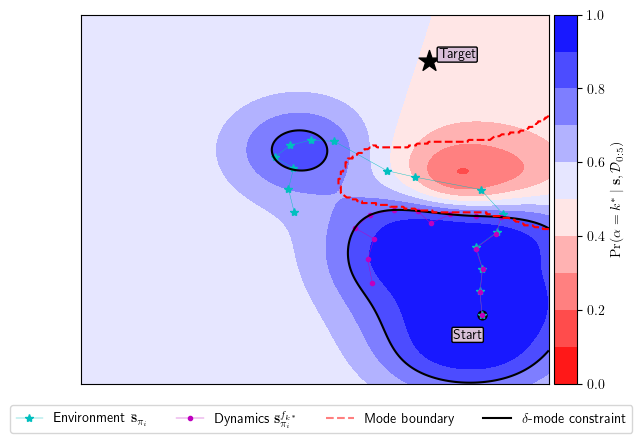

Episode: 5
Finished training dynamics
Finished optimising controller


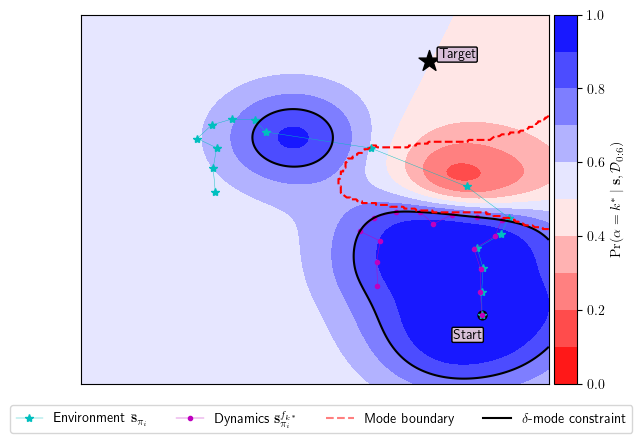

Episode: 6
Finished training dynamics
Finished optimising controller


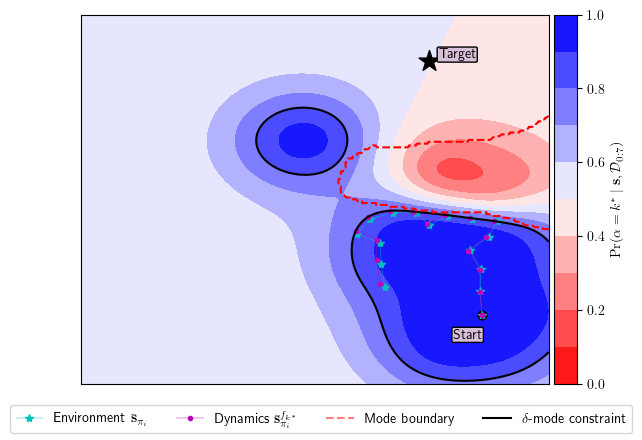

Episode: 7
Finished training dynamics
Finished optimising controller


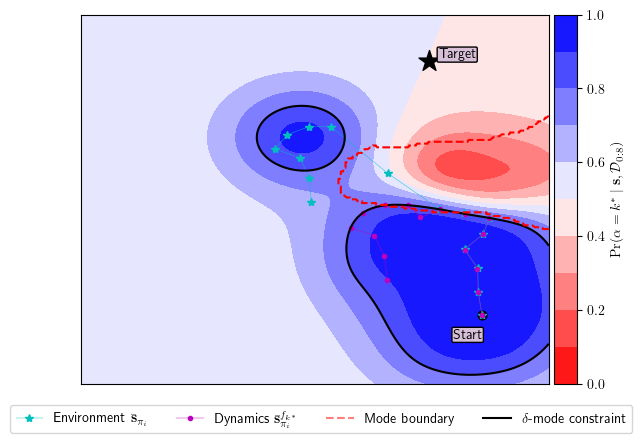

Episode: 8
Finished training dynamics
Finished optimising controller


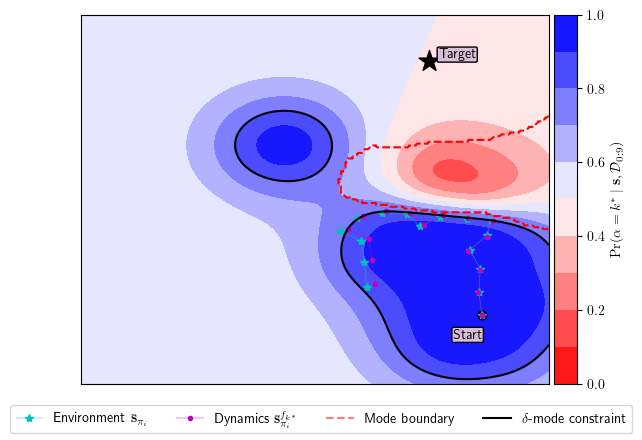

Episode: 9
Finished training dynamics
Finished optimising controller


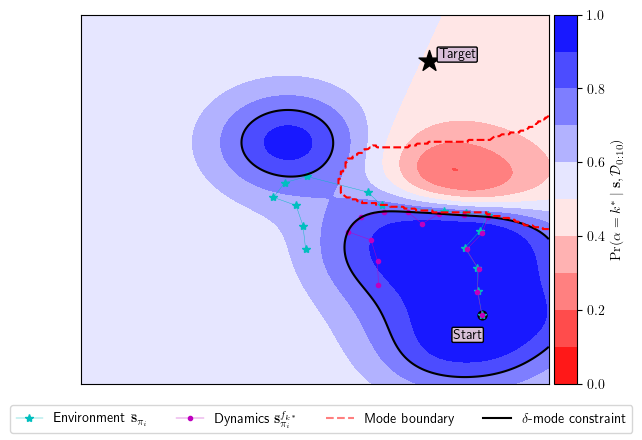

Episode: 10
Finished training dynamics
Finished optimising controller


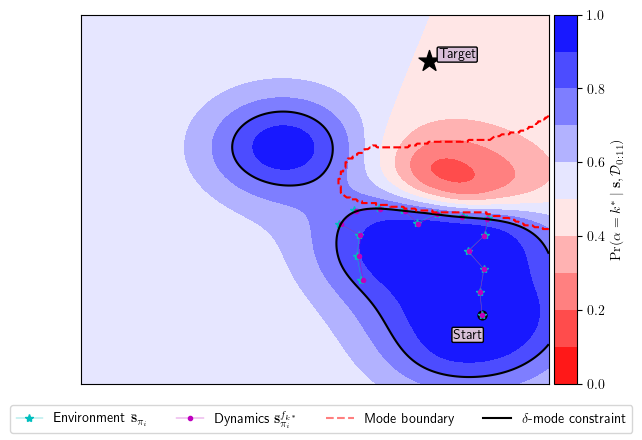

Episode: 11
Finished training dynamics
Finished optimising controller


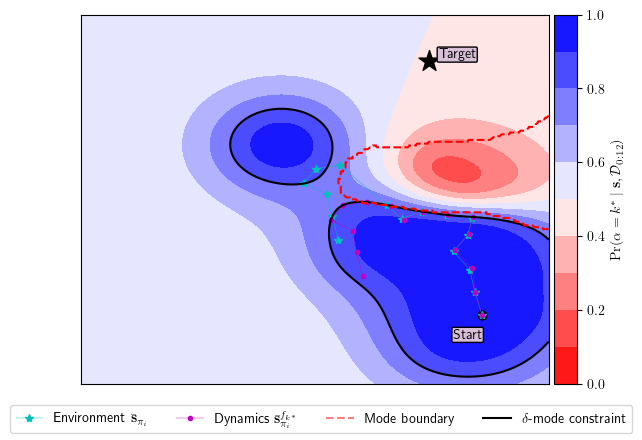

Episode: 12
Finished training dynamics
Finished optimising controller


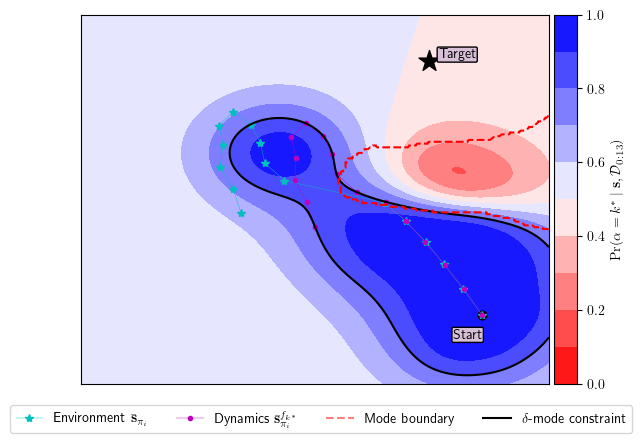

Episode: 13
Finished training dynamics
Finished optimising controller


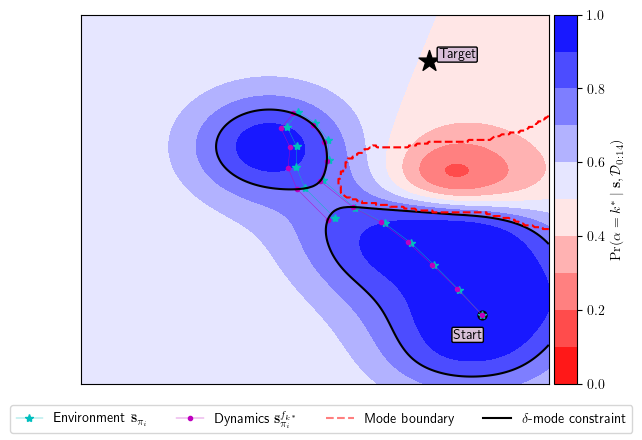

Episode: 14
Finished training dynamics
Finished optimising controller


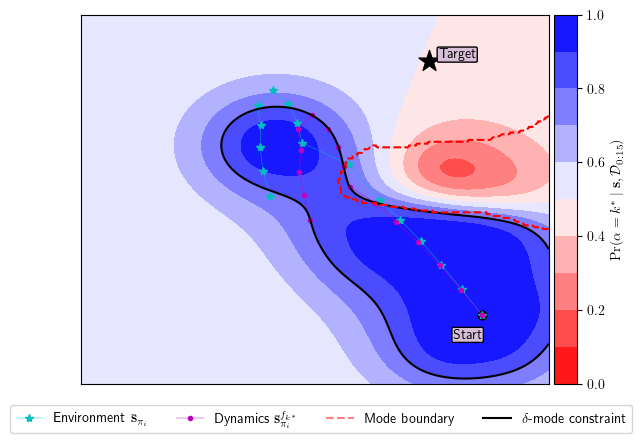

Episode: 15
Finished training dynamics
Finished optimising controller


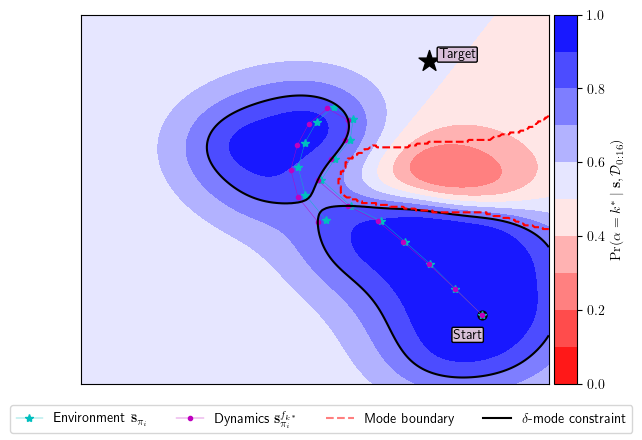

Episode: 16
Finished training dynamics
Finished optimising controller


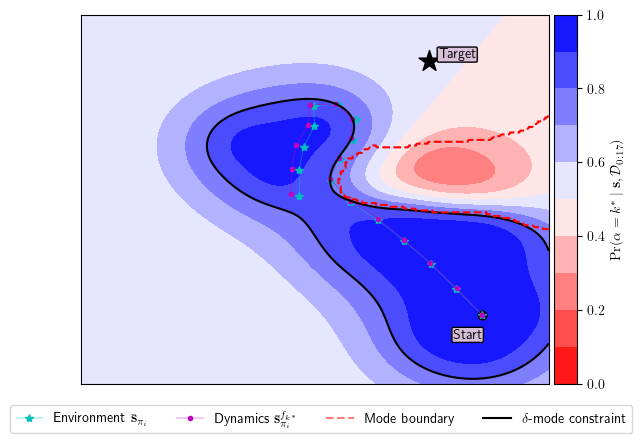

Episode: 17
Finished training dynamics
Finished optimising controller


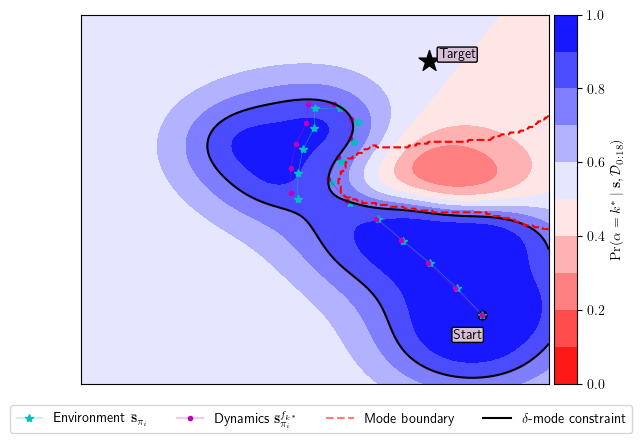

Episode: 18
Finished training dynamics
Finished optimising controller


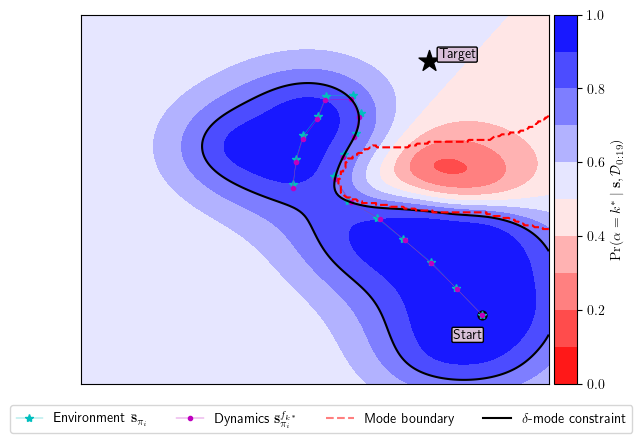

Episode: 19
Finished training dynamics
Finished optimising controller


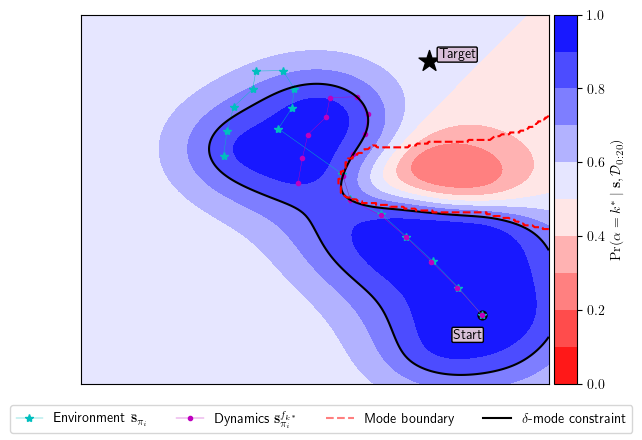

Episode: 20
Finished training dynamics
Finished optimising controller


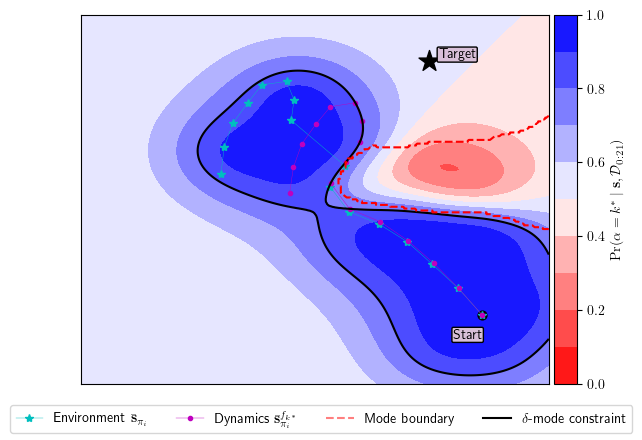

Episode: 21
Finished training dynamics
Finished optimising controller


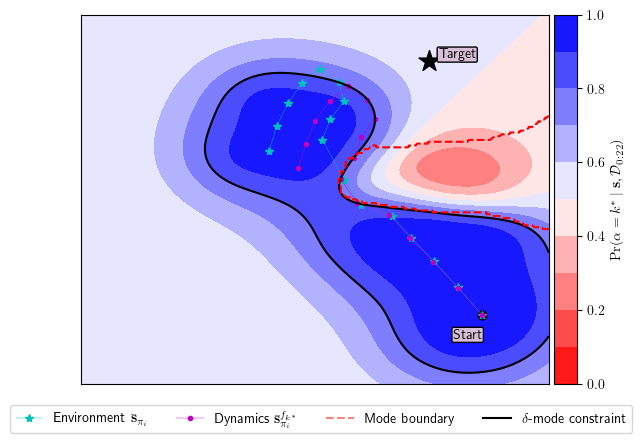

Episode: 22
Finished training dynamics
Finished optimising controller


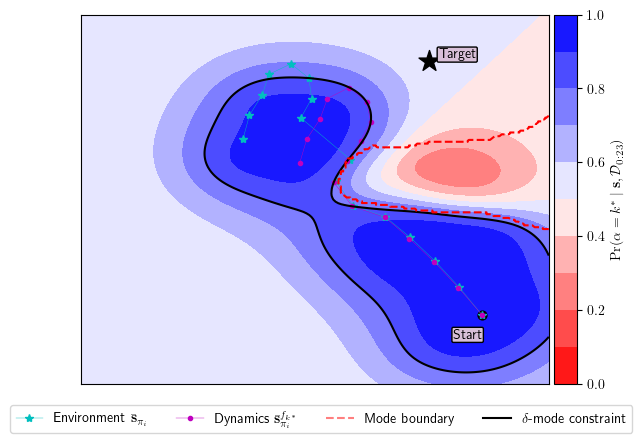

Episode: 23
Finished training dynamics
Finished optimising controller


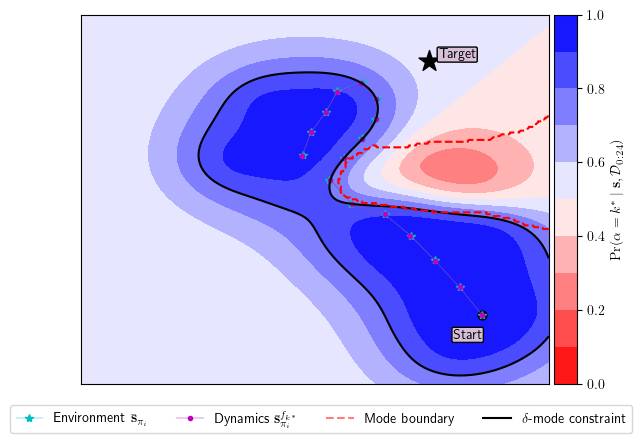

Episode: 24
Finished training dynamics
Finished optimising controller


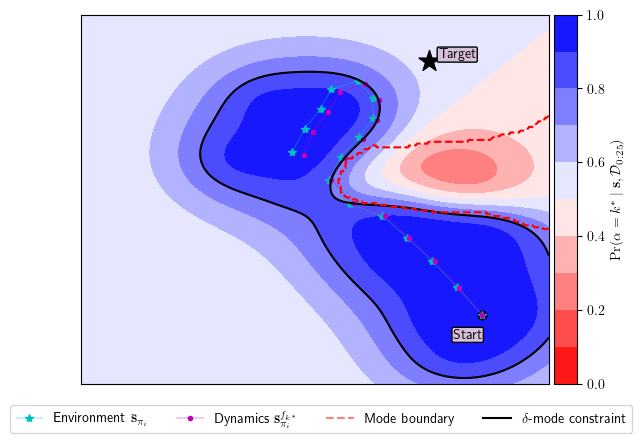

Episode: 25
Finished training dynamics
Finished optimising controller


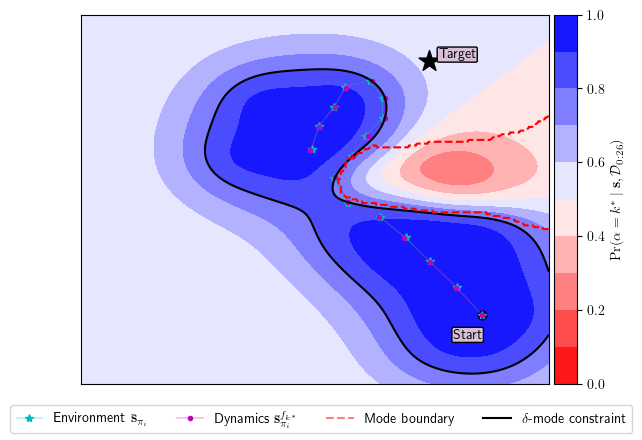

Episode: 26
Finished training dynamics
Finished optimising controller


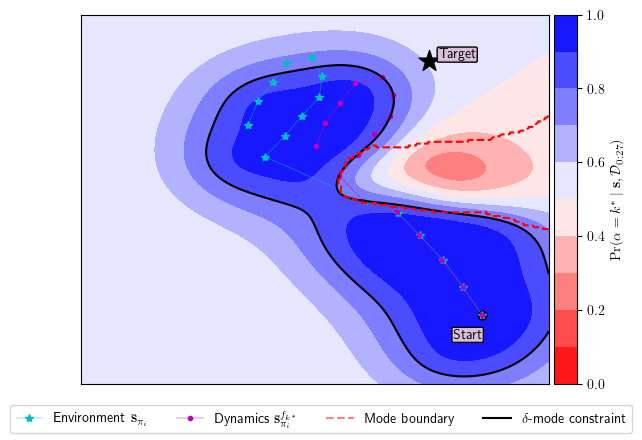

Episode: 27
Finished training dynamics
Finished optimising controller


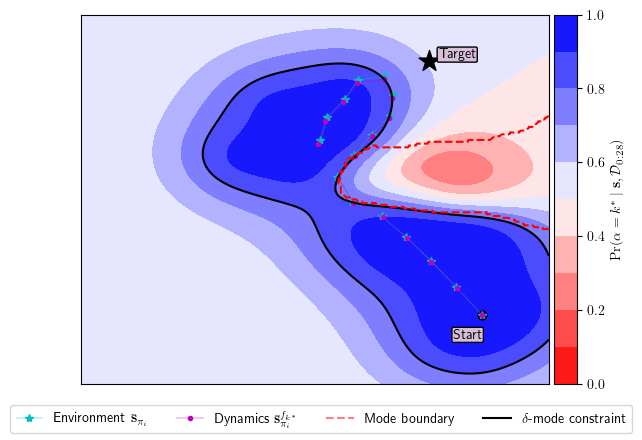

Episode: 28
Finished training dynamics
Finished optimising controller


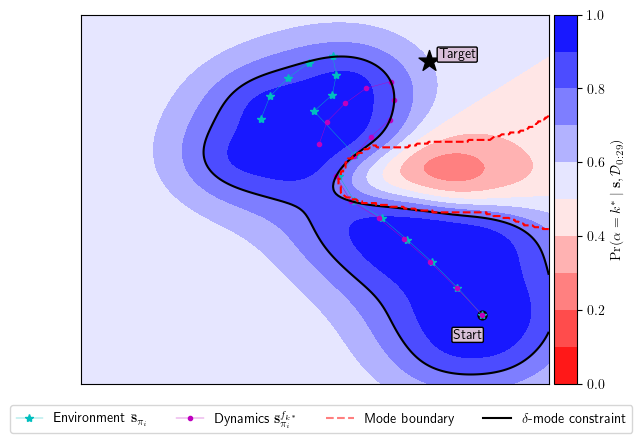

Episode: 29
Finished training dynamics
Finished optimising controller


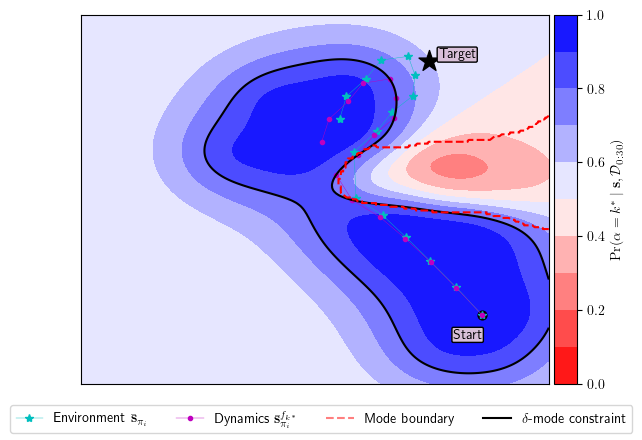

Episode: 30
Finished training dynamics
Finished optimising controller


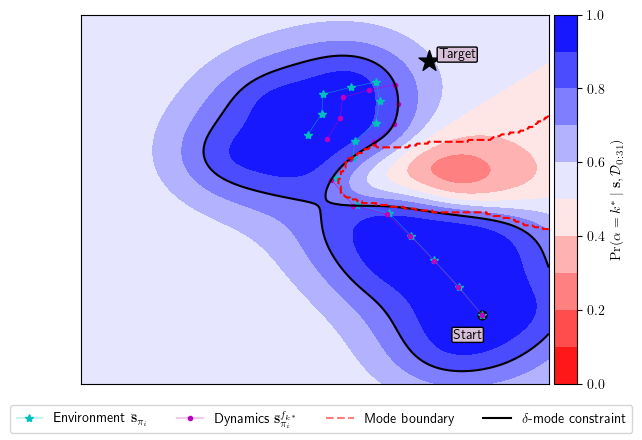

Episode: 31
Finished training dynamics
Finished optimising controller


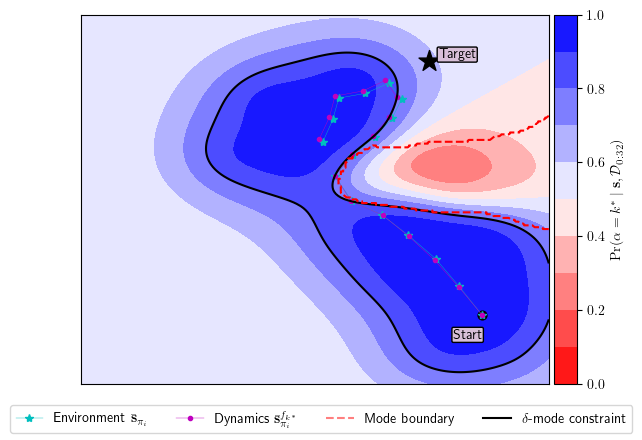

Episode: 32
Finished training dynamics
Finished optimising controller


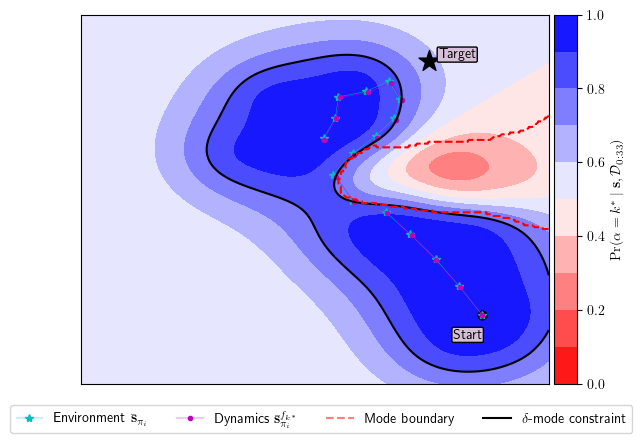

Episode: 33
Finished training dynamics
Finished optimising controller


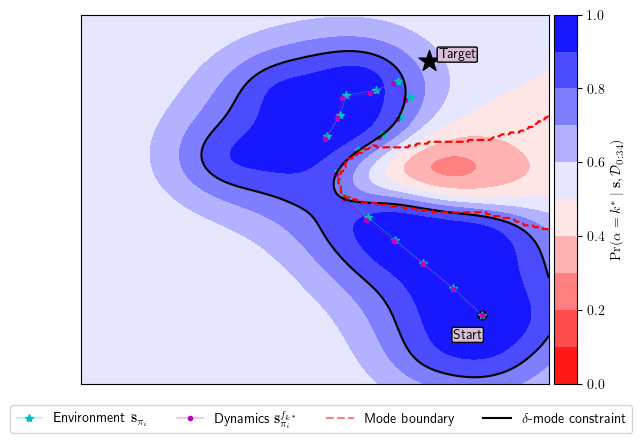

Episode: 34
Finished training dynamics
Finished optimising controller


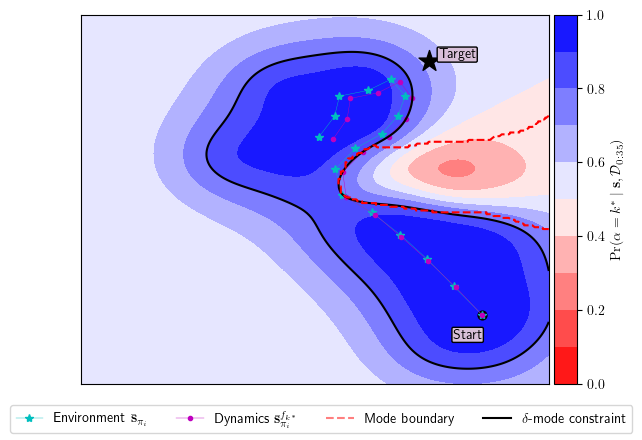

Episode: 35
Finished training dynamics
Finished optimising controller


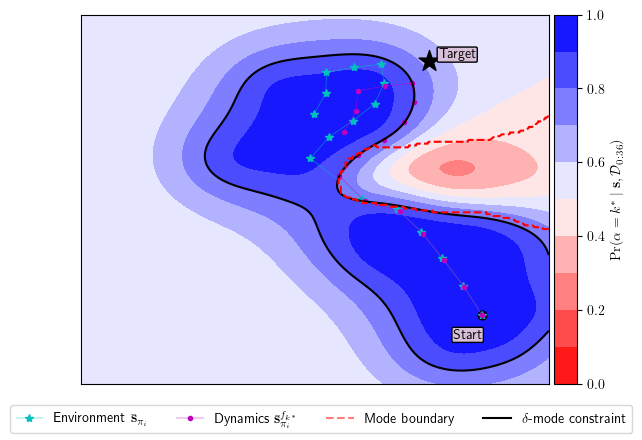

Episode: 36
Finished training dynamics
Finished optimising controller


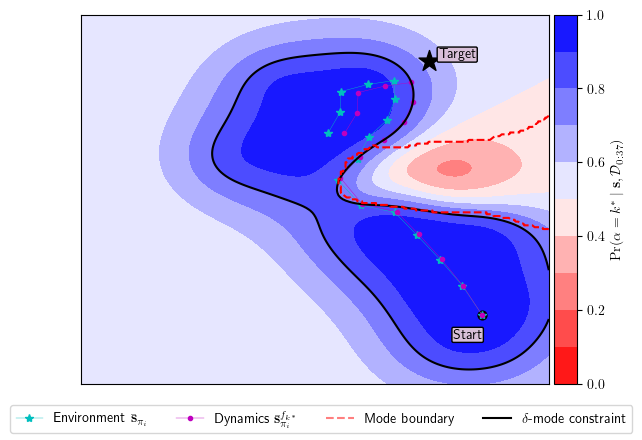

Episode: 37
Finished training dynamics
Finished optimising controller


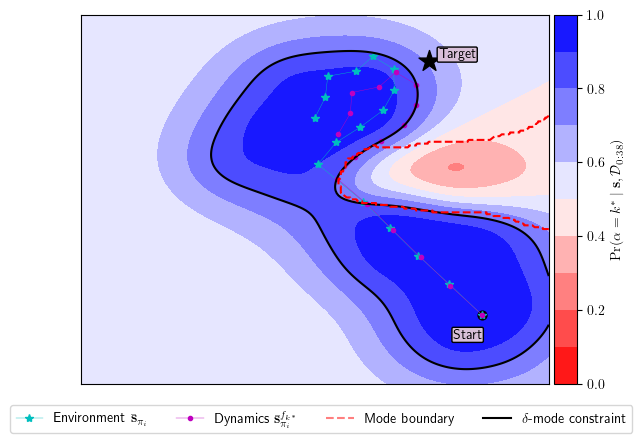

Episode: 38
Finished training dynamics
Finished optimising controller


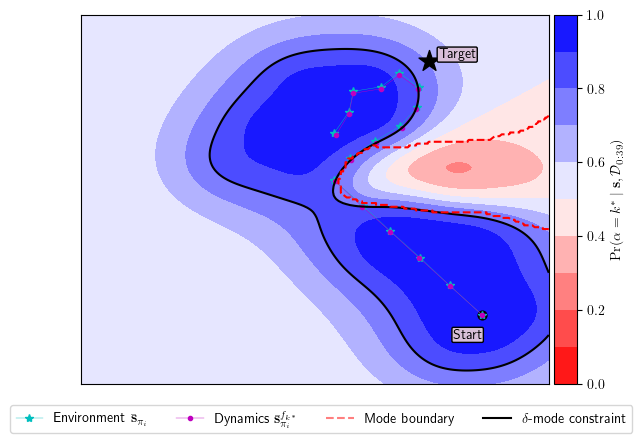

Episode: 39
Finished training dynamics
Finished optimising controller


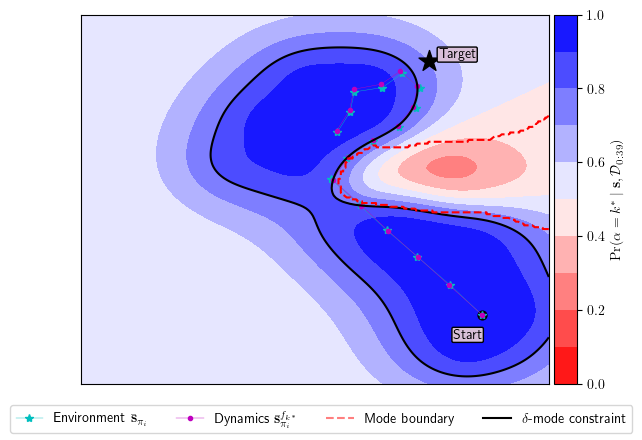

In [25]:
for episode in range(0, num_episodes):
    print("Episode: {}".format(episode))

    # Visualise each episode by plotting trajectory over desired mode's prob
    plot_episode(episode, explorative_controller)

    # Train dynamics model
    dynamics.optimise()
    print("Finished training dynamics")

    # Set the desired mode
    if episode == 0:
        dynamics.desired_mode = set_desired_mode(dynamics)

    # Optimise controller using constrained objective
    _ = explorative_controller.optimise()
    print("Finished optimising controller")

    # Rollout the controller in env to collect state transition data
    X, Y = collect_data_from_env(
        env=env,
        start_state=start_state,
        controls=explorative_controller(),
    )
    dynamics.update_dataset(dataset=(X, Y))

# Visualise final episode
plot_episode(episode, explorative_controller)